## Notebook for understanding the pro-svd pipeline

In [1]:
from proSVD import proSVD
from pro_utils import get_streamingSVD, get_derivs
from pathlib import Path
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from real_spike.utils import get_spike_events, kalman_filter, bin_spikes, butter_filter
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
from matplotlib import colormaps

In [2]:
mat = loadmat("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/MAT_FILES/rb50_20250127_datastruct_pt2.mat")
mat = mat['data']


print(mat.dtype.names)

('totTime', 'cue', 'laser', 'trial_start', 'cue_rec_time', 'cue_trial_time', 'laser_rec_time', 'laser_trial_time', 'field_size', 'pattern_xy', 'field_id', 'full_field', 'pattern_id', 'pattern_fill', 'lift_ms', 'lift', 'grab_ms', 'grab', 'mouth_ms', 'mouth', 'single', 'any', 'no_success')


In [3]:
data_struct = mat[0, 0]  # MATLAB structs are 2D arrays even if 1x1
data = {field: data_struct[field] for field in mat.dtype.names}

In [4]:
data.keys()

dict_keys(['totTime', 'cue', 'laser', 'trial_start', 'cue_rec_time', 'cue_trial_time', 'laser_rec_time', 'laser_trial_time', 'field_size', 'pattern_xy', 'field_id', 'full_field', 'pattern_id', 'pattern_fill', 'lift_ms', 'lift', 'grab_ms', 'grab', 'mouth_ms', 'mouth', 'single', 'any', 'no_success'])

# Get single-reach control trials

In [5]:
# get no laser trials
control_idxs = np.where(data["pattern_id"][:150] == 0)[0] 

In [6]:
#control_idxs = np.sort(np.concatenate((a, b)))
control_idxs

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  21,  27,  33,  39,  45,  51,  57,  63,  69,  75,
        81,  87,  93,  99, 105, 111, 117, 123, 129, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149])

### Only want to look at single reach trials

In [7]:
single_idxs = np.where(data["single"] == 1)[1]
single_idxs

array([  0,   1,   3,   4,   5,   6,   7,   8,   9,  10,  12,  14,  15,
        16,  17,  18,  19,  20,  21,  23,  24,  26,  30,  33,  36,  37,
        38,  39,  40,  41,  43,  44,  45,  46,  48,  49,  50,  51,  52,
        53,  54,  58,  60,  61,  62,  63,  67,  68,  69,  70,  71,  73,
        74,  77,  78,  81,  82,  84,  85,  88,  89,  91, 105, 107, 109,
       116, 117, 121, 122, 130, 137, 139, 145, 148])

In [8]:
control_idxs = np.intersect1d(control_idxs, single_idxs)
control_idxs

array([  0,   1,   3,   4,   5,   6,   7,   8,   9,  10,  12,  14,  15,
        21,  33,  39,  45,  51,  63,  69,  81, 105, 117, 137, 139, 145,
       148])

In [9]:
control_idxs.shape

(27,)

## Get relevant time information

In [10]:
cue_times = data["cue_rec_time"][:, :150]
cue_times[:, control_idxs]

array([[  14310.86566601,   31635.98602851,   66118.75767016,
          83391.57934485,  100671.38676484,  117878.88228075,
         135202.39780987,  152469.08335693,  169748.98517889,
         187076.46559048,  221580.66647786,  256113.84876805,
         343834.9853677 ,  447413.10299254,  654737.65694326,
         758001.60483338,  861313.50892099,  964758.89738507,
        1172344.18955914, 1276101.01010101, 1483298.49900878,
        1897560.18125177, 2104905.22042859, 2466558.2932125 ,
        2501046.72897196, 2604792.2212782 , 2656431.70017936]])

In [11]:
lift_times = data["lift_ms"][:, :150]
lift_times[:, control_idxs]

array([[310., 280., 330., 320., 300., 250., 270.,  90., 260., 260., 230.,
        230., 310., 220., 230., 290., 280., 250., 270., 300., 280., 300.,
        200., 290., 340., 250., 220.]])

In [12]:
mouth_times = data["mouth_ms"][:, :150]
mouth_times[:, control_idxs]

array([[540., 540., 560., 570., 520., 540., 600., 460., 510., 490., 500.,
        530., 510., 510., 490., 590., 520., 530., 620., 510., 520., 570.,
        560., 530., 570., 590., 480.]])

## Get the AP.bin file

In [13]:
from real_spike.utils import get_sample_data, get_meta
import tifffile

In [14]:
file_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.bin")
meta_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.meta")

In [15]:
meta_data = get_meta(meta_path)

In [16]:
ap_data = get_sample_data(file_path, meta_data)
ap_data.shape

(385, 166298223)

## Get conversion params

In [17]:
vmax = float(meta_data["imAiRangeMax"])
# get Imax
imax = float(meta_data["imMaxInt"])
# get gain
gain = float(meta_data['imroTbl'].split(sep=')')[1].split(sep=' ')[3])

In [18]:
vmax

0.6

In [19]:
imax

512.0

In [20]:
gain

500.0

In [21]:
all_data = list()
#explained_variances = list()

# HYPERPARAMETERS TO TOGGLE
bin_size = 30
Q=1e-2

for i in tqdm(control_idxs):
    trial_no = i
    # get time points in ap space
    lift_time = int((cue_times[:, trial_no] + lift_times[:, trial_no] - 50) / 1_000 * 30_000)
    
    # get end of behavior = mouth (260ms) + 300ms 
    end_behavior = int((cue_times[:, trial_no] + mouth_times[:, trial_no] + 260 + 300) / 1_000 * 30_000)
    #print(lift_time, end_behavior)

    trial = ap_data[:150, lift_time:end_behavior]

    conv_data = 1e6 * trial / vmax / imax / gain

    filt_data = butter_filter(conv_data, 1_000, 30_000)

    c_start = int(cue_times[:, trial_no] / 1_000 * 30_000)
    m_start = c_start - (30 * 2000)
    trial_median = ap_data[:150, m_start:c_start]

    trial_median = 1e6 * trial_median / vmax / imax / gain
    trial_median = butter_filter(trial_median, 1_000, 30_000)
    
    median = np.median(trial_median, axis=1)

    spike_ixs, counts = get_spike_events(filt_data, median)
    
    a = np.zeros((filt_data.shape[0], filt_data.shape[1]))

    for i, sc in enumerate(spike_ixs):
        a[i, sc] = 1

    b = bin_size * 30 # 30ms per bin
    binned_spikes = bin_spikes(a, b)

    smoothed = kalman_filter(binned_spikes, Q=Q)

    all_data.append(smoothed)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:12<00:00,  2.13it/s]


In [22]:
svd_data = list()

lift_start = int(50 / bin_size)
after_lift = int(300 / bin_size) + lift_start

for d in all_data:
    svd_data.append(d[:, lift_start:after_lift])

d = np.concatenate(svd_data, axis=1)

# Running pro-svd

In [23]:
k = 6  # reduced dim
l = 10    # num cols processed per iter
decay = 1 # 'forgetting' to track nonstationarity. 1 = no forgetting
l1 = k   # num cols init
num_iters = np.floor((d.shape[1] - l1) / l).astype('int') # num iters to go through data once
update_times = np.arange(1, num_iters) * l # index of when updates happen
num_iters

26

In [24]:
projs = [np.zeros((k, d.shape[1]-l1)) for i in range(2)]  # subtract l1 - init proj
frac_vars = [np.zeros(projs[i].shape) for i in range(2)]



In [25]:
A_init = d[:, :l1]
pro = proSVD(k, w_len=l, w_shift=None, decay_alpha=decay, history=num_iters, trueSVD=True)
pro.initialize(A_init) 

In [26]:
for i, t in enumerate(update_times): 
    dat = d[:, t:t+l]
    pro.updateSVD(dat, ref_basis=None)
    # getting proj and variance explained
    for j, basis in enumerate([pro.U, pro.Q]):
        projs[j][:, t:t+l] = basis.T @ dat
        curr_proj_vars = projs[j][:, :t-l1].var(axis=1)[:, np.newaxis]
        total_vars = d[:, :t].var(axis=1)
        frac_vars[j][:, t:t+l] = curr_proj_vars / total_vars.sum()
    # proSVD basis derivatives
  #  derivs[:, i] = np.linalg.norm(pro.Q_prev - pro.Q, axis=0)

In [27]:
u, s, v = np.linalg.svd(d, full_matrices=False)
u = u[:, :k]
basis = pro.Q
res1 = np.linalg.norm(basis - u @ u.T @ basis)
res2 = np.linalg.norm(u - basis @ basis.T @ u)

print(res1, res2)

#fig, ax = plt.subplots() 
#ax.plot(derivs.T)

0.6501904163250154 0.650190416325015


In [51]:
proj = pro.Q.T @ all_data[0]
var_proj = np.var(proj, axis=1)

In [52]:
proj.shape

(6, 28)

In [53]:
var_explained

array([788.46399977, 278.1671747 ,  56.27417098,  24.81181926,
        12.74226459,  85.59954149])

In [54]:
var_total = np.sum(np.var(proj, axis=0))  # across features

# Explained variance ratio
var_proj / var_total   

array([0.00638073, 0.0022511 , 0.0004554 , 0.00020079, 0.00010312,
       0.00069272])

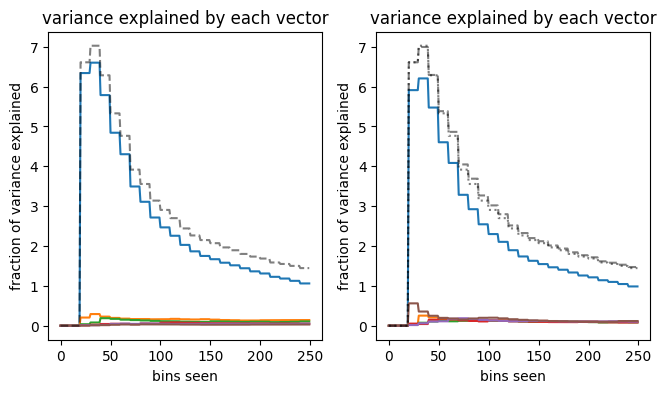

In [28]:
dists = np.linalg.norm(pro.Qs - pro.Q[:, :, np.newaxis], axis=0)

fig, ax = plt.subplots(1, 3, figsize=(12,4))

for j in range(2):
    ax[j+1].plot(frac_vars[j][:, :t].T)
    ax[j+1].plot(frac_vars[j].sum(axis=0)[:t], ls='--', color='k', alpha=0.5)
    ax[j+1].set(title='variance explained by each vector', 
            xlabel='bins seen', ylabel='fraction of variance explained')

ax[2].plot(frac_vars[0].sum(axis=0)[:t], ls=':', color='k', alpha=0.5)

ax[0].remove()

In [29]:
def get_trial_PCA(trial, pro):

    X = trial
    proj = pro.U.T @ X                      # shape: (k, T)
    total_var = np.sum(X ** 2)                # scalar
    per_comp_var = np.sum(proj ** 2, axis=1)  # shape: (k,)
    explained_ratio = per_comp_var / total_var  # shape: (k,)

    return proj.T, explained_ratio.sum()

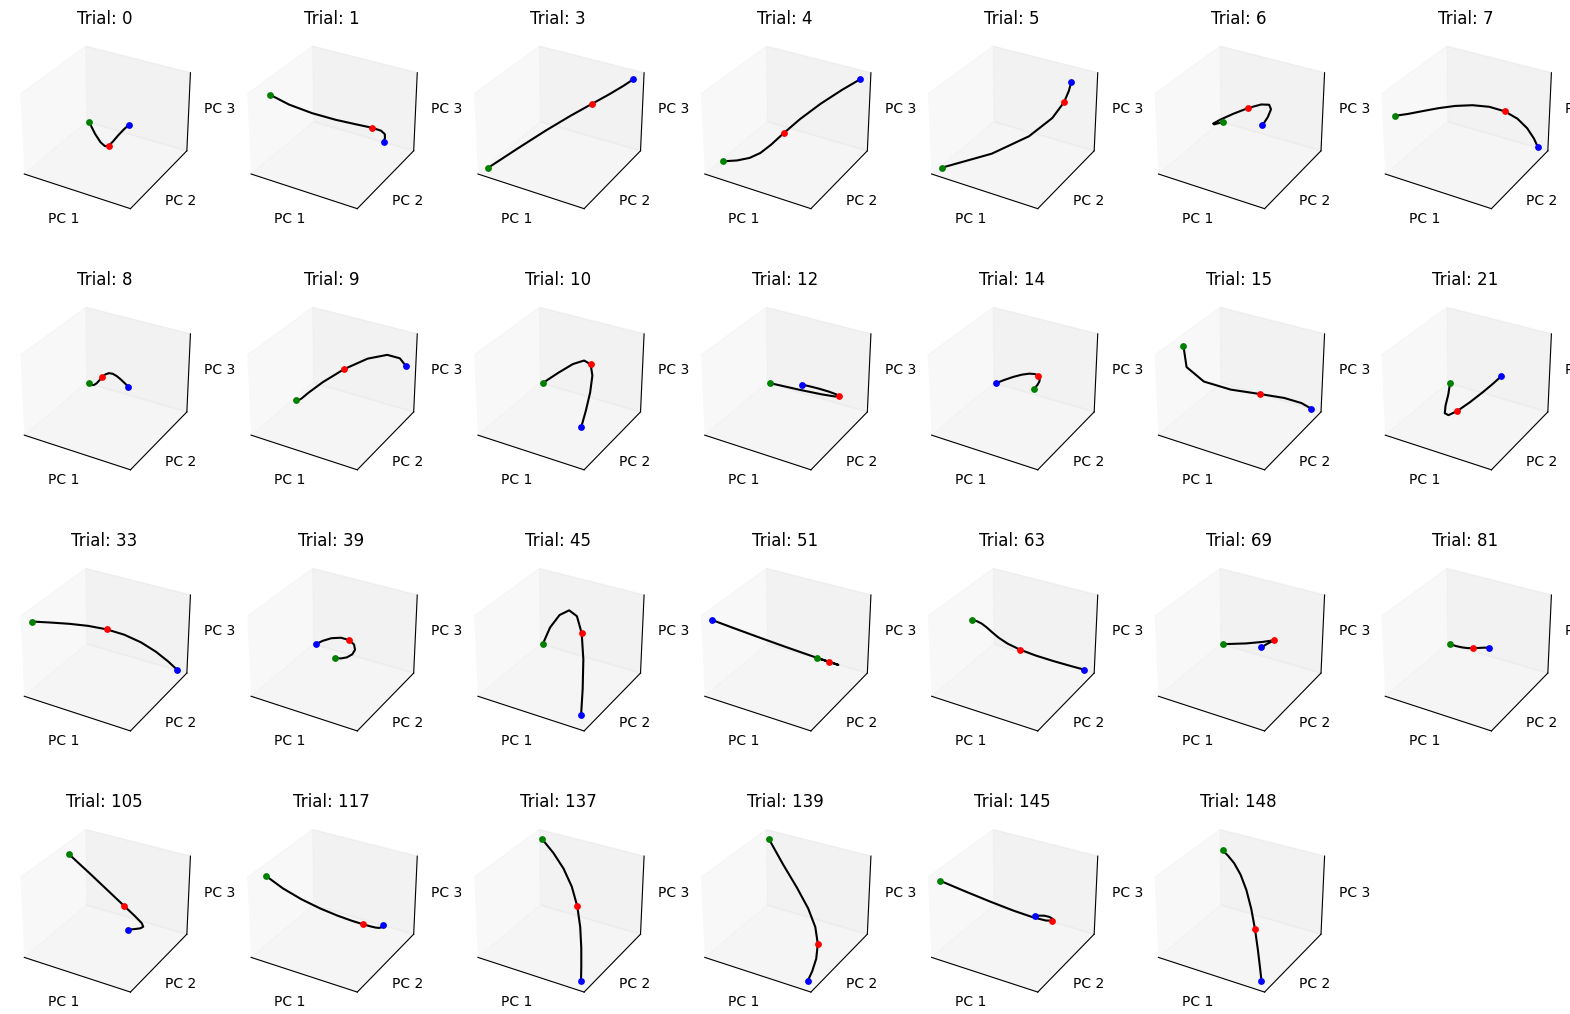

In [37]:
fig, axes = plt.subplots(4, 7, figsize=(20, 13), subplot_kw=dict(projection='3d'))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, p in enumerate(all_data):

    p, explained_var = get_trial_PCA(p, pro)
    
    lift = int(data["lift_ms"][0, control_idxs[i]] / bin_size) 
    # grab duration
    grab = int(data["grab_ms"][0,control_idxs[i]] / bin_size)
    # mouth duration 
    mouth = int(data["mouth_ms"][0,control_idxs[i]] / bin_size)

    lift_start = int(50 / bin_size)
    grab_start = lift_start + (grab - lift)
    mouth_start = lift_start + (mouth-lift)

    # p = gaussian_filter1d(p, sigma=0.05)
    p = gaussian_filter1d(p, sigma=3, axis=0)

    #axes[i].scatter(p[:, 0], p[:, 1], s=1, c=colors)
    axes[i].plot(p[lift_start:mouth_start+1, 0], p[lift_start:mouth_start+1, 1], p[lift_start:mouth_start+1, 2], c="black")
    axes[i].set_xlabel(f"PC 1", labelpad=-7) 
    axes[i].set_ylabel(f"PC 2", labelpad=-7) 
    axes[i].set_zlabel(f"PC 3", labelpad=-7)
    axes[i].set_title(f"Trial: {control_idxs[i]}")
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_zticks([])


    axes[i].scatter(p[lift_start, 0], p[lift_start, 1], p[lift_start, 2], s=15, c="blue")
    axes[i].scatter(p[grab_start, 0], p[grab_start, 1], p[grab_start, 2], s=15, c="red")
    axes[i].scatter(p[mouth_start, 0], p[mouth_start, 1], p[mouth_start, 2], s=15, c="green")

axes[-1].remove() 

plt.savefig(f'/home/clewis/repos/realSpike/data/rb50_20250127/ProSVD_control_{bin_size}ms.png')

/tmp/ipykernel_42369/1845462285.py:4: RuntimeWarning: invalid value encountered in divide
  vals = (Ss[:6, :]**2) / (Ss[:, :]**2).sum(axis=0)


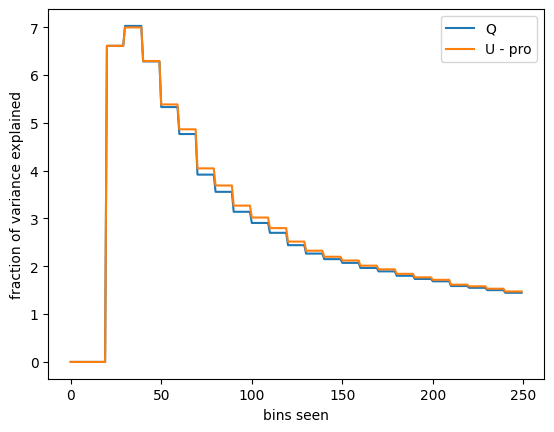

In [40]:
Us, Ss = get_streamingSVD(d, k, l1, l, num_iters, window=False)

#%% looking at stuff
vals = (Ss[:6, :]**2) / (Ss[:, :]**2).sum(axis=0)
fig, ax = plt.subplots()
for i in range(2):
    ax.plot(frac_vars[i].sum(axis=0)[:t])
#ax.plot(vals.sum(axis=0), ls='--', color='k')
ax.set(xlabel='bins seen', ylabel='fraction of variance explained')
ax.legend(labels=['Q', 'U - pro', 'U - dumb streaming'])